In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/distilgpt2-ft-2-epochs/transformers/default/1/config.json
/kaggle/input/distilgpt2-ft-2-epochs/transformers/default/1/merges.txt
/kaggle/input/distilgpt2-ft-2-epochs/transformers/default/1/training_args.bin
/kaggle/input/distilgpt2-ft-2-epochs/transformers/default/1/vocab.json
/kaggle/input/distilgpt2-ft-2-epochs/transformers/default/1/tokenizer_config.json
/kaggle/input/distilgpt2-ft-2-epochs/transformers/default/1/pytorch_model.bin
/kaggle/input/distilgpt2-ft-2-epochs/transformers/default/1/special_tokens_map.json
/kaggle/input/distilgpt2-ft-2-epochs/transformers/default/1/generation_config.json
/kaggle/input/distilgpt2-ft-3-epochs/transformers/default/1/config.json
/kaggle/input/distilgpt2-ft-3-epochs/transformers/default/1/merges.txt
/kaggle/input/distilgpt2-ft-3-epochs/transformers/default/1/training_args.bin
/kaggle/input/distilgpt2-ft-3-epochs/transformers/default/1/vocab.json
/kaggle/input/distilgpt2-ft-3-epochs/transformers/default/1/tokenizer_config.json
/kaggle

In [2]:
!pip install evaluate
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=3be5cbfb8f181b1484b68b37bb9a30c1477a06ede8e29bfd743f8628cb98218b
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [3]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, pipeline
from datasets import load_dataset
import evaluate
from tqdm import tqdm

### Download the Base DistilGPT2 Model

In [4]:
# Load the pre-trained DistilGPT-2 model and tokenizer
model_name = "distilgpt2"
tokenizer_base = GPT2Tokenizer.from_pretrained(model_name)
model_base = GPT2LMHeadModel.from_pretrained(model_name)

# Set pad_token_id to eos_token_id to prevent eos token error
model_base.config.pad_token_id = model_base.config.eos_token_id

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### Download the fine-tuned models

In [5]:
# Download 1 Epoch Trained Model
one_epoch_path = "/kaggle/input/distilgpt2-ft-1-epoch/transformers/default/1"
tokenizer_1 = GPT2Tokenizer.from_pretrained(one_epoch_path)
model_1 = GPT2LMHeadModel.from_pretrained(one_epoch_path)

# Download 2 Epoch Trained Model
two_epoch_path = "/kaggle/input/distilgpt2-ft-2-epochs/transformers/default/1"
tokenizer_2 = GPT2Tokenizer.from_pretrained(two_epoch_path)
model_2 = GPT2LMHeadModel.from_pretrained(two_epoch_path)

# Download 3 Epoch Trained Model
three_epoch_path = "/kaggle/input/distilgpt2-ft-3-epochs/transformers/default/1"
tokenizer_3 = GPT2Tokenizer.from_pretrained(three_epoch_path)
model_3 = GPT2LMHeadModel.from_pretrained(three_epoch_path)

In [6]:
# Load the SQuAD dataset (validation set subset for quick testing)
squad = load_dataset("squad", split="validation[:100]")

README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [7]:
# Initialize ROUGE evaluator
rouge = evaluate.load("rouge")

In [8]:
# Generate answers for SQuAD dataset
def generate_answers(model, tokenizer, dataset):
    
    references = []
    predictions = []
    
    # Initialize a text generation pipeline and set `pad_token_id` to `eos_token_id`
    generator = pipeline(
        "text-generation", 
        model=model, 
        tokenizer=tokenizer, 
        pad_token_id=tokenizer.eos_token_id  # Set pad_token_id here
    )

    for sample in tqdm(dataset, desc="Processing samples"):
        question = sample['question']
        context = sample['context']

        # Create input text combining question and context
        input_text = f"Question: {question} Context: {context} Answer:"

        # Generate the answer from the fine-tuned model with max_new_tokens
        generated_answer = generator(input_text, max_new_tokens=50, num_return_sequences=1)[0]['generated_text']

        # Extract the generated answer (strip the prompt part)
        answer_start_idx = generated_answer.find('Answer:') + len('Answer:')
        predicted_answer = generated_answer[answer_start_idx:].strip()

        # Collect predictions and references
        references.append(sample['answers']['text'][0])  # SQuAD has multiple answers, pick the first one
        predictions.append(predicted_answer)
        
    return references, predictions

### Calculate ROUGE score for base model

In [9]:
references_base, predictions_base = generate_answers(model_base, tokenizer_base, squad)

# Compute the ROUGE score between predictions and references
results_base = rouge.compute(predictions=predictions_base, references=references_base)

Processing samples: 100%|██████████| 100/100 [02:09<00:00,  1.29s/it]


### Calculate ROUGE score for 1 Epoch model

In [10]:
references_1, predictions_1 = generate_answers(model_1, tokenizer_1, squad)

# Compute the ROUGE score between predictions and references
results_1 = rouge.compute(predictions=predictions_1, references=references_1)

Processing samples: 100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


### Calculate ROUGE score for 2 Epoch model

In [11]:
references_2, predictions_2 = generate_answers(model_2, tokenizer_2, squad)

# Compute the ROUGE score between predictions and references
results_2 = rouge.compute(predictions=predictions_2, references=references_2)

Processing samples: 100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


### Calculate ROUGE score for 3 Epoch model

In [12]:
references_3, predictions_3 = generate_answers(model_3, tokenizer_3, squad)

# Compute the ROUGE score between predictions and references
results_3 = rouge.compute(predictions=predictions_3, references=references_3)

Processing samples: 100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


In [13]:
# Print the results
print("ROUGE base scores:", results_base)
print()
print("-" * 50)
print()
print("ROUGE 1 Epoch scores:", results_1)
print()
print("-" * 50)
print()
print("ROUGE 2 Epoch scores:", results_2)
print()
print("-" * 50)
print()
print("ROUGE 3 Epoch scores:", results_3)

ROUGE base scores: {'rouge1': 0.013634083467215261, 'rouge2': 0.005780372614161943, 'rougeL': 0.013860381768596122, 'rougeLsum': 0.013687396859505218}

--------------------------------------------------

ROUGE 1 Epoch scores: {'rouge1': 0.061298953687146426, 'rouge2': 0.028730351232142716, 'rougeL': 0.06151859286804934, 'rougeLsum': 0.06123216380874525}

--------------------------------------------------

ROUGE 2 Epoch scores: {'rouge1': 0.06124470554208176, 'rouge2': 0.028375649200998512, 'rougeL': 0.06109355234753598, 'rougeLsum': 0.0609797945367553}

--------------------------------------------------

ROUGE 3 Epoch scores: {'rouge1': 0.0624581531162923, 'rouge2': 0.030664903671666955, 'rougeL': 0.06273502046946515, 'rougeLsum': 0.06285486343130836}


### Display ROUGE Scores

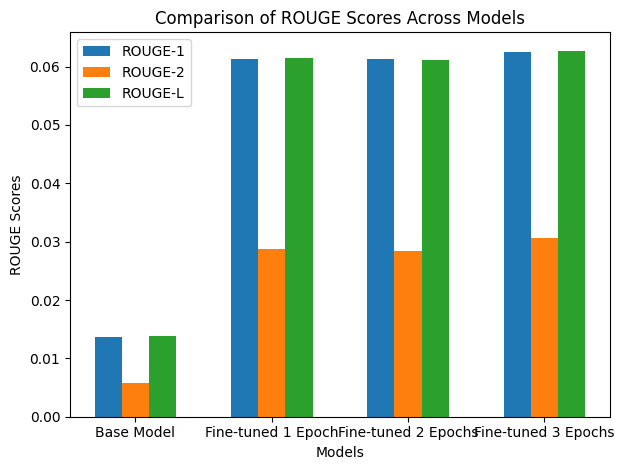

In [14]:
import matplotlib.pyplot as plt
import numpy as np

rouge_results = [results_base, results_1, results_2, results_3]

# Combine all scores into arrays

rouge_1_scores = [rouge["rouge1"] for rouge in rouge_results]
rouge_2_scores = [rouge["rouge2"] for rouge in rouge_results]
rouge_l_scores = [rouge["rougeL"] for rouge in rouge_results]

# Labels for each model
labels = ['Base Model', 'Fine-tuned 1 Epoch', 'Fine-tuned 2 Epochs', 'Fine-tuned 3 Epochs']

# Create the bar width and positions
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

# Initialize the plot
fig, ax = plt.subplots()

# Plot each group of ROUGE scores
bars1 = ax.bar(x - width, rouge_1_scores, width, label='ROUGE-1')
bars2 = ax.bar(x, rouge_2_scores, width, label='ROUGE-2')
bars3 = ax.bar(x + width, rouge_l_scores, width, label='ROUGE-L')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('ROUGE Scores')
ax.set_title('Comparison of ROUGE Scores Across Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()